<a href="https://colab.research.google.com/github/VishalDavasam/i.mobilothon-3.0/blob/main/semantic_segmentation_with_u_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a class="anchor" id="1" name='1'></a>
## **1. Import Required Packages**

In [1]:
import numpy as np
import pandas as pd
import imageio
import random
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Activation, Input, Conv2D, MaxPooling2D, BatchNormalization, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model, load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, load_model

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<a class="anchor" id="2" name="2"></a>
## **2. Data Preparation**

The Lyft Udacity Semantic Segmentation for Self-driving Cars Challenge data (images and masks) is splitted across five directories (dataA, dataB, dataC, dataD, and dataE). As part of the data preparation step, we will load images and masks from all the five directories and carry out the a few preprocessing steps to ensure we provide our model with quality dataset.

<a class="anchor" id="2-1" name="2-1"></a>
### **2.1. Load the images and masks from their directories**

In this data preparation step, we will:
1. Create 2 lists containing the paths of images and masks
2. Split the lists into training, validation and test sets

#### **2.1.1. Create lists containing the paths of images and masks**

In this step, we will

* Create a list that contains all the paths to all directories in the main directory (a list that contains the path to dataA, dataB, dataC, dataD, and dataE)
* Create a function to iterate over all the direcory paths where our data are located (list in 1.) and return the list of the image paths in those directories.
* Create lists of image and mask paths by initializing the function above
* Preview some masked and unmasked images by reading them from their paths

**A. Create a list that contains all the paths to all directories in the main directory (a list that contains the path to dataA, dataB, dataC, dataD, and dataE)**

In [ ]:
image_path = ["/content/drive/MyDrive/"+"data"+i+"/"+"data"+i+"/CameraRGB/" for i in ['A']]
mask_path = ["/content/drive/MyDrive/"+"data"+i+"/"+"data"+i+"/CameraSeg/" for i in ['A']]

**Create a function to iterate over all the direcory paths where our data are located (list in 2.1.1.) and return the list of the image paths in those directories**

In [ ]:
def list_image_paths(directory_paths):
    image_paths = []
    for directory in range(len(directory_paths)):
        image_filenames = os.listdir(directory_paths[directory])
        for image_filename in image_filenames:
            image_paths.append(directory_paths[directory] + image_filename)
    return image_paths


**Create lists of image and mask paths by initializing the function above**

In [ ]:
image_paths = list_image_paths(image_path)
mask_paths = list_image_paths(mask_path)
number_of_images, number_of_masks = len(image_paths), len(mask_paths)
print(f"1. There are {number_of_images} images and {number_of_masks} masks in our dataset")
print(f"2. An example of an image path is: \n {image_paths[0]}")
print(f"3. An example of a mask path is: \n {mask_paths[0]}")
image_paths.sort()
mask_paths.sort()

1. There are 1000 images and 1000 masks in our dataset
2. An example of an image path is: 
 /content/drive/MyDrive/dataA/dataA/CameraRGB/02_00_090.png
3. An example of a mask path is: 
 /content/drive/MyDrive/dataA/dataA/CameraSeg/02_00_001.png


**Preview random masked and unmasked images by reading them from their paths**

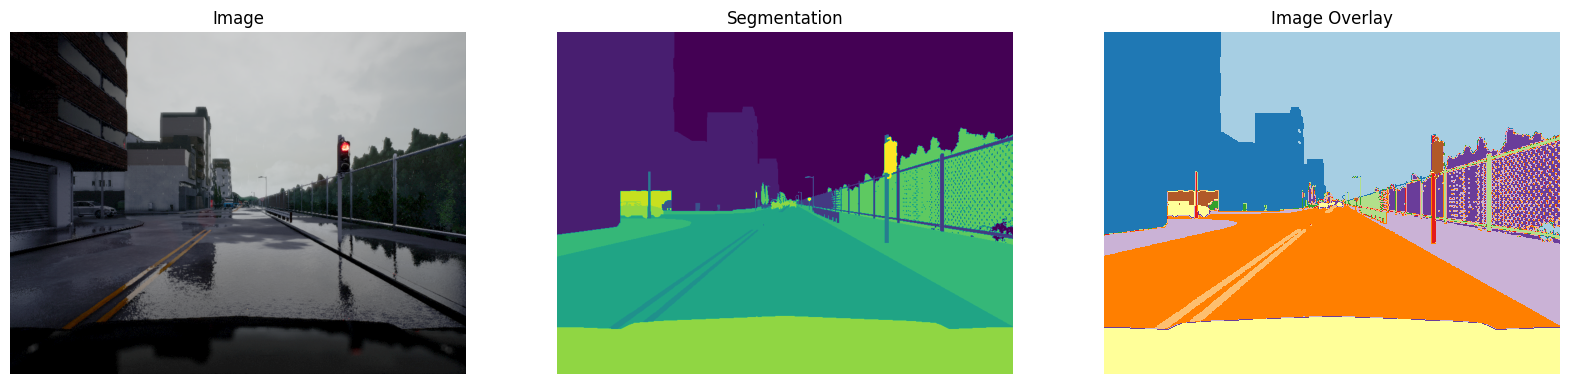

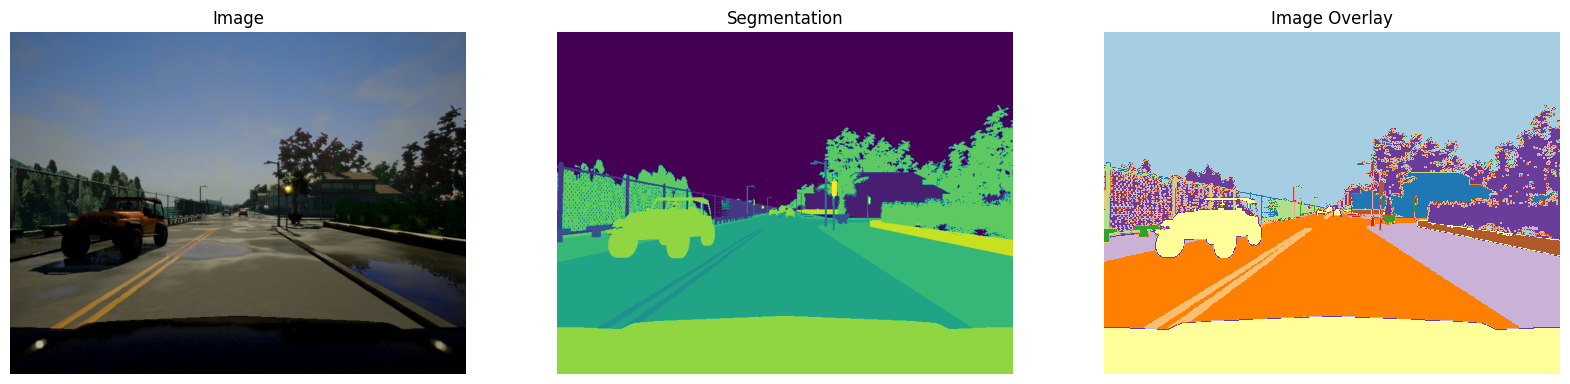

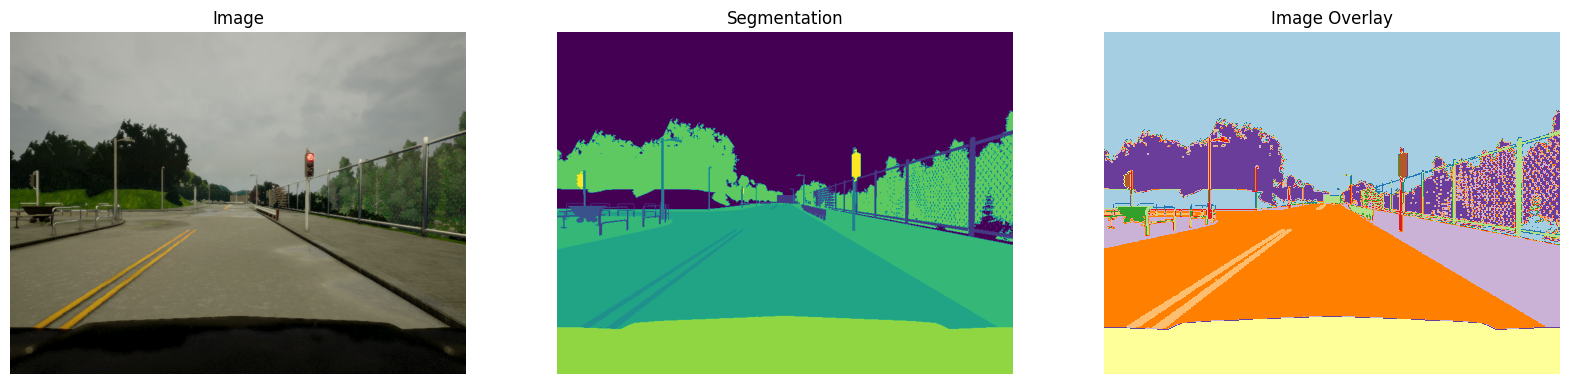

In [ ]:
import random
number_of_samples = len(image_paths)

for i in range(3):
    N = random.randint(0, number_of_samples - 1)

    img = imageio.imread(image_paths[N])
    mask = imageio.imread(mask_paths[N])
    mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

    fig, arr = plt.subplots(1, 3, figsize=(20, 8))
    arr[0].imshow(img)
    arr[0].set_title('Image')
    arr[0].axis("off")
    arr[1].imshow(mask)
    arr[1].set_title('Segmentation')
    arr[1].axis("off")
    arr[2].imshow(mask, cmap='Paired')
    arr[2].set_title('Image Overlay')
    arr[2].axis("off")

#### **2.1.2. Split the image and mask paths into training, validation, and test sets**

In [ ]:
# First split the image paths into training and validation sets
train_image_paths, val_image_paths, train_mask_paths, val_mask_paths = train_test_split(image_paths, mask_paths, train_size=0.8, random_state=0)

# Keep part of the validation set as test set
validation_image_paths, test_image_paths, validation_mask_paths, test_mask_paths = train_test_split(val_image_paths, val_mask_paths, train_size = 0.80, random_state=0)

print(f'There are {len(train_image_paths)} images in the Training Set')
print(f'There are {len(validation_image_paths)} images in the Validation Set')
print(f'There are {len(test_image_paths)} images in the Test Set')

There are 800 images in the Training Set
There are 160 images in the Validation Set
There are 40 images in the Test Set


<a class="anchor" id="2-2" name="2-2"></a>
### **2.2. - Create a data pipeline to read and preprocess our data**

We will be using the tf.data.Dataset API to load our images and masks for our model to process. The Dataset API allows us to build an asynchronous, highly optimized data pipeline to prevent our GPU from data starvation. It loads data from the disk (images or text), applies optimized transformations, creates batches and sends it to the GPU. Unlike former data pipelines made the GPU, the Dataset API wait for the CPU to load the data, leading to performance issues.

To do this, we will
1. Create a function to read image and mask paths and return equivalent arrays
2. Create a data generator function to read and load images and masks in batches
3. Create data pipelines for the training, validation and test sets using both functions
4. Preview sample images and their segmentations from the three dataset categories

#### **2.2.1. Create a function to read image and mask paths and return equivalent arrays**

The **read_image** function will
1. Read an image and its mask from their paths
2. Convert the digital image and its mask to image arrays
3. Normalize the datasets
4. Resize the image and its masks to a desired dimension

In [ ]:
def read_image(image_path, mask_path):

    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (256, 256), method='nearest')

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    mask = tf.image.resize(mask, (256, 256), method='nearest')

    return image, mask

#### **2.2.2. Create a data generator function to read and load images and masks in batches**

In [ ]:
def data_generator(image_paths, mask_paths, buffer_size, batch_size):

    image_list = tf.constant(image_paths)
    mask_list = tf.constant(mask_paths)
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(read_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache().shuffle(buffer_size).batch(batch_size)

    return dataset

#### **2.2.3. Create data pipelines for the training, validation and test sets using both functions**

In [ ]:
batch_size = 32
buffer_size = 500

train_dataset = data_generator(train_image_paths, train_mask_paths, buffer_size, batch_size)
validation_dataset = data_generator(validation_image_paths, validation_mask_paths, buffer_size, batch_size)
test_dataset = data_generator(test_image_paths, test_mask_paths, buffer_size, batch_size)

<a class="anchor" id="3" name="3"></a>
## **3. Model Architecture and Training**
We will using a the **U-Net architecture** to train our semantic segmentation model. The U-Net model was named for its U-shape architecture, and it was originally created for biomedical image segmentation tasks in 2015. However, the model has become a very popular choice for other semantic segmentation tasks.

U-Net builds on a previous architecture called the Fully Convolutional Network, or FCN, which replaces the dense layers found in a typical CNN with a transposed convolution layer that upsamples the feature map back to the size of the original input image, while preserving the spatial information. This is necessary because the dense layers destroy spatial information (the "where" of the image), which is an essential part of image segmentation tasks. An added bonus of using transpose convolutions is that the input size no longer needs to be fixed, as it does when dense layers are used.

The U-Net architecture consists of:

**1. Contracting path (Encoder containing downsampling steps)**:

The contracting path follows a regular CNN architecture, with convolutional layers, their activations, and pooling layers to downsample the image and extract its features. Images are first fed through several convolutional layers which reduce height and width, while growing the number of channels.

In detail, it consists of the repeated application of two 3 x 3 unpadded convolutions, each followed by a rectified linear unit (ReLU) and a 2 x 2 max pooling operation with stride 2 for downsampling. At each downsampling step, the number of feature channels is doubled.

During the contracting process, convolution outputs are stored in a separate variable before size reduction (pooling of features). This is passed to the expanding blocks during the decoding process as feature map.


**2. Expanding path (Decoder containing upsampling steps)**:

The expanding path performs the opposite operation of the contracting path, growing the image back to its original size, while shrinking the channels gradually.

In detail, each step in the expanding path upsamples the feature map, followed by a 2 x 2 convolution (the transposed convolution or upsampling). This transposed convolution halves the number of feature channels, while growing the height and width of the image.

Next is a concatenation with the correspondingly cropped feature map from the contracting path, and two 3 x 3 convolutions, each followed by a ReLU.


**3. Final Feature Mapping Block**: In the final layer, a 1x1 convolution is used to map each 64-component feature vector to the desired number of classes. The channel dimensions from the previous layer correspond to the number of filters used, so when you use 1x1 convolutions, you can transform that dimension by choosing an appropriate number of 1x1 filters. When this idea is applied to the last layer, you can reduce the channel dimensions to have one layer per class.

The U-Net network has 23 convolutional layers in total.
<center><img src="https://i.ibb.co/0287bZ1/U-Net.webp" alt="U-Net" border="0"></center>


<a class="anchor" id="3-1" name="3-1"></a>

### **3.1. U-Net Model Design**

To design our model, we will carry out the following steps
1. Define a function for an encoding block. The function will return the next layer output and the skip connection output for the corresponding block in the model
2. Define a function for a decoding block. This function will merge the skip-connection input with the previous layer, process it, and return an output
3. Develop a model using both the encoding and decoding blocks output

##### **3.1.1. Define a function for an encoding block (This function will return the next layer output and the skip connection output for the corresponding block in the model)**

In [ ]:
def encoding_block(inputs, filters, dropout_probability=0, max_pooling=True):

    """
    Convolutional encoding/downsampling block

    Arguments:
        inputs -- Input tensor
        filters -- Number of filters for the convolutional layers
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns:
        next_layer, skip_connection --  Next layer and skip connection inputs
    """

    C = Conv2D(filters, 3, padding="same", kernel_initializer="he_normal")(inputs)
    C = BatchNormalization()(C)
    C = Activation("relu")(C)

    C = Conv2D(filters, 3, padding="same", kernel_initializer="he_normal")(C)
    C = BatchNormalization()(C)
    C = Activation("relu")(C)

    skip_connection = C  # Set aside residual

    # if max_pooling is True, add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2, 2))(C)
    else:
        next_layer = C

    return next_layer, skip_connection

##### **3.1.2. Define a function for a decoding block (This function will merge the skip-connection input with the previous layer, process it, and return an output)**

In [ ]:
def decoding_block(inputs, skip_connection_input, filters):
    """
    Convolutional decoding/upsampling block

    Arguments:
        inputs -- Input tensor from previous layer
        skip_connection_input -- Input tensor from previous skip layer
        filters -- Number of filters for the convolutional layers
    Returns:
        C -- Tensor output
    """

    CT = Conv2DTranspose(filters, 3, strides=(2,2), padding="same", kernel_initializer="he_normal")(inputs)

    residual_connection = concatenate([CT, skip_connection_input], axis=3)

    C = Conv2D(filters, 3, padding="same", kernel_initializer="he_normal")(residual_connection)
    C = BatchNormalization()(C)
    C = Activation("relu")(C)

    C = Conv2D(filters, 3, padding="same", kernel_initializer="he_normal")(C)
    C = BatchNormalization()(C)
    C = Activation("relu")(C)


    return C

##### **3.1.3. Develop a model using both the encoding and decoding blocks output**

In [ ]:
def unet_model(input_size, filters, n_classes):
    """
    Unet model

    Arguments:
        input_size -- Input shape
        filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns:
        model -- tf.keras.Model
    """
    inputs = Input(input_size)

    # Contracting Path (encoding)
    C1, S1 = encoding_block(inputs, filters, max_pooling=True)
    C2, S2 = encoding_block(C1, filters * 2, max_pooling=True)
    C3, S3 = encoding_block(C2, filters * 4, max_pooling=True)
    C4, S4 = encoding_block(C3, filters * 8, max_pooling=True)

    C5, S5 = encoding_block(C4, filters * 16, max_pooling=False)

    # Expanding Path (decoding)
    U6 = decoding_block(C5, S4, filters * 8)
    U7 = decoding_block(U6, S3,  filters * 4)
    U8 = decoding_block(U7, S2,  filters = filters * 2)
    U9 = decoding_block(U8, S1,  filters = filters)

    C10 = Conv2D(filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(U9)

    # Add a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
    C11 = Conv2D(filters = n_classes, kernel_size = (1,1), activation='sigmoid', padding='same')(C10)

    model = Model(inputs=inputs, outputs=C11)

    return model

In [ ]:
img_height = 256
img_width = 256
num_channels = 3
filters = 32
n_classes = 13

model = unet_model((img_height, img_width, num_channels), filters=32, n_classes=23)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

<a class="anchor" id="3-2" name="3-2"></a>
### **3.2. Model Training**

In [ ]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
callback = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',factor=1e-1, patience=5, verbose=1, min_lr = 2e-6)
batch_size = 32
epochs = 5

In [ ]:
history = model.fit(train_dataset,
                    validation_data = validation_dataset,
                    epochs = epochs,
                    verbose=1,
                    callbacks = [callback, reduce_lr],
                    batch_size = batch_size,
                    shuffle = True)

Epoch 1/5
25/25 [==============================] - 365s 6s/step - loss: 1.6194 - accuracy: 0.5650 - val_loss: 22.9809 - val_accuracy: 0.2607 - lr: 0.0010
Epoch 2/5
25/25 [==============================] - 21s 835ms/step - loss: 0.5820 - accuracy: 0.8521 - val_loss: 9.5825 - val_accuracy: 0.3549 - lr: 0.0010
Epoch 3/5
25/25 [==============================] - 23s 909ms/step - loss: 0.3912 - accuracy: 0.8967 - val_loss: 4.4992 - val_accuracy: 0.5777 - lr: 0.0010
Epoch 4/5
25/25 [==============================] - 22s 873ms/step - loss: 0.3112 - accuracy: 0.9123 - val_loss: 2.5174 - val_accuracy: 0.6091 - lr: 0.0010
Epoch 5/5
25/25 [==============================] - 22s 900ms/step - loss: 0.2734 - accuracy: 0.9195 - val_loss: 1.1504 - val_accuracy: 0.7169 - lr: 0.0010


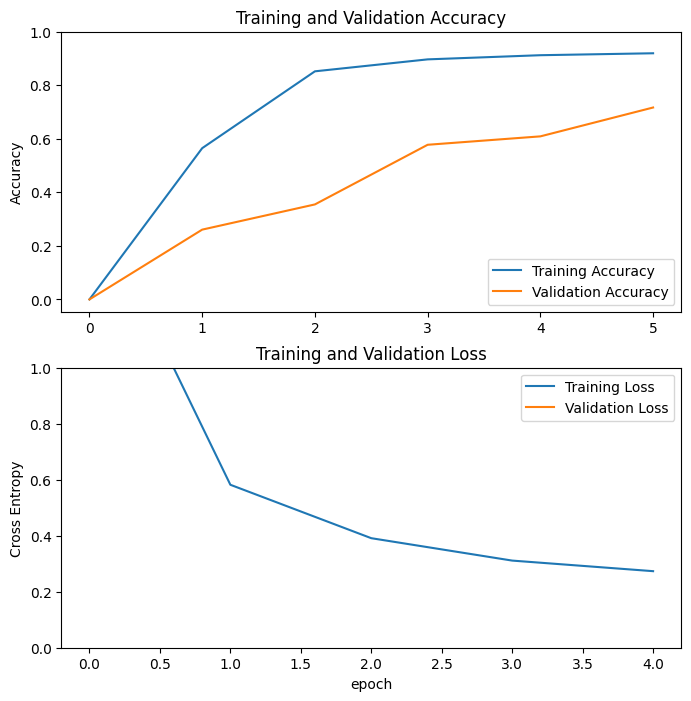

In [ ]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
model.save('carla-image-segmentation-model.h5')

<a class="anchor" id="3-3" name="3-3"></a>
### **3.3. Compute Model Accuracy**

In [ ]:
train_loss, train_accuracy = model.evaluate(train_dataset, batch_size = 32)
validation_loss, validation_accuracy = model.evaluate(validation_dataset, batch_size = 32)
test_loss, test_accuracy = model.evaluate(test_dataset, batch_size = 32)

2/2 [==============================] - 17s 3s/step - loss: 1.1009 - accuracy: 0.7269


In [ ]:
print(f'Model Accuracy on the Training Dataset: {round(train_accuracy * 100, 2)}%')
print(f'Model Accuracy on the Validation Dataset: {round(validation_accuracy * 100, 2)}%')
print(f'Model Accuracy on the Test Dataset: {round(test_accuracy * 100, 2)}%')

<a class="anchor" id="4" name="4"></a>
## **4. Model Evaluation**

Model Evaluation is an integral part of the model development process. It helps to find the best model that represents our data and how well the chosen model will work in the future. For classification tasks, precision and recall are the popular choice metrics used in addition with model accuracy to evaluate model performance since model accuracy is not always sufficient to judge if a model is optimal or not (especially if our dataset is skewed). The same rule applies to most dense prediction tasks like image segmentation where the goal is to simplify and/or change the representation of an image into classes that is more meaningful and easier to analyze.


Since the goal of our model is to partition an input image into various classes, it is often difficult to know if our model struggles to optimally partition one or more classes since it doesn't always reflect in the model accuracy, neither can it easily detected by the eyes. Hence, there is a need for supplementary metrics to evaluate model performance.

In this project, we will be using recall,precision, specificity, true detection rate (TDR), Intersection over Union (IoU), and F1-score as supplementary metrics to evaluate our model performance. These metrics were computed by identifying the variables true positive (TP), true negative (TN), false positive (FP), and false-negative (FN) by calculating the confusion matrix between the predicted segmentations and the ground truth segmentations. The expressions for these metrics are defined as:

1. Precision = TP/(TP + FP)
2. Recall/Sensitivity = TP/(TP + FN)
3. Specificity = TN/(TN + FP)
4. True Detection Rate (TDR) = 1 - (FN/(TP + FN))
5. Intersection over Union (IoU)/Jaccard Similarity  = TP/(TP + FP + FN)
6. F1-score(JS)/Dice coefficient = 2 * ((Precision * Recall)/(Precision + Recall))

<br/>

To carry out these evaluations, we will:
1. Create segmentations/masks of images in our dataset
2. Evaluate predicted segmentations


<a class="anchor" id="4-1" name="4-1"></a>
### **4.1. Create Segmentations/Masks of Images in our Dataset**

In [ ]:
def create_mask(dataset, model):
    true_masks, predicted_masks = [], []
    for images, masks in dataset:
        pred_masks = model.predict(images)
        pred_masks = tf.expand_dims(tf.argmax(pred_masks, axis=-1), axis=-1)
        true_masks.extend(masks)
        predicted_masks.extend(pred_masks)

    true_masks = np.array(true_masks)
    predicted_masks = np.array(predicted_masks)

    return true_masks, predicted_masks

In [ ]:
true_train_masks, predicted_train_masks = create_mask(train_dataset, model)
true_validation_masks, predicted_validation_masks = create_mask(validation_dataset, model)
true_test_masks, predicted_test_masks = create_mask(test_dataset, model)

1/1 [==============================] - 0s 381ms/step


<a class="anchor" id="4-2" name="4-2"></a>
### **4.2. Evaluate Predicted Segmentations**

In [ ]:
def evaluate_model(true_masks, predicted_masks, n_classes, smooth = 1e-6):

    """
    Evaluates semantic segmentation model

    Argument:
        true_masks: ground truth segmentations
        predicted_masks: predicted segmentations
        n_classes: number of segmentation classes
        smooth: a minute float digit added to denominators to avoid error from a zero division

    Returns:
        class_wise_evaluations: a dictionary containing evaluation metric
                                outputs the for each segmentation class
        overall_evaluations: a dictionary containing evaluation metric
                             outputs the for all segmentation classes
        """
    # Create empty lists to store evaluation metric outputs
    class_wise_true_positives, class_wise_true_negatives = [],[]
    class_wise_false_positives, class_wise_false_negatives = [],[]
    class_wise_precisions, class_wise_recalls = [],[]
    class_wise_specificities, class_wise_ious = [],[]
    class_wise_tdrs, class_wise_f1_scores = [],[]
    classes = []

    for clas in range(n_classes):
        true_positives, true_negatives, false_positives, false_negatives = 0,0,0,0
        precisions, recalls, specificities, ious, f1_scores, tdrs = 0,0,0,0,0,0

        number_of_masks = true_masks.shape[0]

        for mask_id in range(number_of_masks):
            true_positive = np.sum(np.logical_and(true_masks[mask_id]==clas, predicted_masks[mask_id]==clas))
            true_negative = np.sum(np.logical_and(true_masks[mask_id]!=clas, predicted_masks[mask_id]!=clas))
            false_positive = np.sum(np.logical_and(true_masks[mask_id]!=clas, predicted_masks[mask_id]==clas))
            false_negative = np.sum(np.logical_and(true_masks[mask_id]==clas, predicted_masks[mask_id]!=clas))

            true_positives += true_positive
            true_negatives += true_negative
            false_positives += false_positive
            false_negatives += false_negative

        recall = round(true_positives/(true_positives + false_negatives + smooth), 2)
        precision = round(true_positives/(true_positives + false_positives + smooth), 2)
        specificity = round(true_negatives/(true_negatives + false_positives + smooth), 2)
        tdr = round((1 - (false_negatives/(true_positives + false_negatives + smooth))), 2)
        iou = round(true_positives/(true_positives + false_negatives + false_positives + smooth), 2)
        f1_score = round((2 * precision * recall)/(precision + recall + smooth), 2)

        class_wise_true_positives.append(true_positives)
        class_wise_true_negatives.append(true_negatives)
        class_wise_false_positives.append(false_positives)
        class_wise_false_negatives.append(false_negatives)
        class_wise_recalls.append(recall)
        class_wise_precisions.append(precision)
        class_wise_specificities.append(specificity)
        class_wise_ious.append(iou)
        class_wise_tdrs.append(tdr)
        class_wise_f1_scores.append(f1_score)
        classes.append("Class " + str(clas+1))
        # class_wise_pixel_accuracies.append(pixel_accuracy)

    total_true_positives = np.sum(class_wise_true_positives)
    total_true_negatives = np.sum(class_wise_true_negatives)
    total_false_positives = np.sum(class_wise_false_positives)
    total_false_negatives = np.sum(class_wise_false_negatives)
    mean_recall = round(np.average(np.array(class_wise_recalls)), 2)
    mean_precision = round(np.average(np.array(class_wise_precisions)), 2)
    mean_specificity = round(np.average(np.array(class_wise_specificities)), 2)
    mean_iou = round(np.average(np.array(class_wise_ious)), 2)
    mean_tdr = round(np.average(np.array(class_wise_tdrs)), 2)
    mean_f1_score = round(np.average(np.array(class_wise_f1_scores)), 2)

    class_wise_evaluations = {"Class": classes,
                              "True Positive Pixels": class_wise_true_positives,
                              "True Negative Pixels": class_wise_true_negatives,
                              "False Positive Pixels": class_wise_false_positives,
                              "False Negative Pixels": class_wise_false_negatives,
                              "Recall": class_wise_recalls,
                              "Precision": class_wise_precisions,
                              "Specificity": class_wise_specificities,
                              "IoU": class_wise_ious,
                              "TDR": class_wise_tdrs,
                              "F1-Score": class_wise_f1_scores}

    overall_evaluations = {"Class": "All Classes",
                        "True Positive Pixels": total_true_positives,
                        "True Negative Pixels": total_true_negatives,
                        "False Positive Pixels": total_false_positives,
                        "False Negative Pixels": total_false_negatives,
                        "Recall": mean_recall,
                        "Precision": mean_precision,
                        "Specificity": mean_specificity,
                        "IoU": mean_iou,
                        "TDR": mean_tdr,
                        "F1-Score": mean_f1_score}

    evaluations = {"Overall Evaluations": overall_evaluations,
                   "Class-wise Evaluations": class_wise_evaluations}

    return evaluations

In [ ]:
def show_evaluations(evaluations,
                     metrics=["Recall", "Precision", "Specificity", "IoU", "TDR", "F1 Score"],
                     class_list=None,
                     display_evaluations="All"):
    """
    Returns a pandas dataframe containing specified metrics

        Arguments:
            evaluations: evaluation output from the evaluate_model function
            metrics: a list containing one or more of the following metrics:
                     'True Positive', 'True Negative', 'False Positive', 'False Negative',
                     'Recall', 'Precision', 'Specificity', 'F1 Score', 'IoU', 'TDR'
            display_evaluations: one of 'All' to display both overall and class-wise evaluations,
                                 'Overall' to display only the overall evaluations,
                                 'Class-wise' to display only the classwise evaluations.
            class_list: list or tuple containing names of segmentation class.
    """

    # Split evaluations into overall and class-wise evaluations
    overall_evaluations = evaluations["Overall Evaluations"]
    class_wise_evaluations = evaluations["Class-wise Evaluations"]

    # Validate list of metrics
    for metric_id in range(len(metrics)):
        metric = metrics[metric_id]
        if metric not in overall_evaluations:
            raise ValueError("'metrics argument' not properly defined. "
                            "Kindly create a list containing one or more of the following metrics: "
                             "'True Positive', 'True Negative', 'False Positive', 'False Negative', "
                             "'Recall', 'Precision', 'Specificity', 'F1 Score', 'IoU', 'TDR'")

    # Check if class_list is none
    if class_list != None and all(isinstance(class_, str) for class_ in class_list):
        if len(class_list) == len(class_wise_evaluations["Class"]):
            class_list = [class_list]
        else:
            raise ValueError("class_list argument' not properly defined. "
                             "List is either shorter or longer than segmentation classes")
    else:
        class_list = [class_wise_evaluations["Class"]]

    # Extract data from the evaluations
    overall_data = [overall_evaluations["Class"]] + [overall_evaluations[metrics[metric_id]] for metric_id in range(len(metrics))]
    classwise_data = class_list + [class_wise_evaluations[metrics[metric_id]] for metric_id in range(len(metrics))]
    overall_data = np.array(overall_data).reshape(1,-1)
    classwise_data = np.array(classwise_data).transpose()

    # Determine the type of evaluation report to display
    if display_evaluations.lower() == "all":
        data = np.concatenate((overall_data, classwise_data), axis=0)
    elif display_evaluations.lower() == "overall":
        data = overall_data
    elif display_evaluations.lower() == "class-wise" or "classwise":
        data = classwise_data
    else:
        raise ValueError("Display argument are not properly defined."
                        "Kindly use 'All' to display both overall and class-wise evaluations."
                        "Use 'Overall' to display only the overall evaluations."
                        "Or use 'Class-wise' to display only the class-wise evaluations")


    # Create evaluation report as a pandas dataframe
    dataframe = pd.DataFrame(data)
    dataframe_titles = ["Class"] + metrics
    dataframe.columns = dataframe_titles
    # dataframe = dataframe.set_index(dataframe_titles[0], col_level=1)

    return dataframe

#### **4.2.1. Evaluate predicted segmentations of the training images**

In [ ]:
model_evaluation_on_train_dataset = evaluate_model(true_train_masks, predicted_train_masks, n_classes=13)

show_evaluations(model_evaluation_on_train_dataset,
                 metrics=["Recall", "Precision", "Specificity", "IoU", "TDR", "F1-Score"],
                 class_list=None,
                 display_evaluations="All")

,Class,Recall,Precision,Specificity,IoU,TDR,F1-Score
0,All Classes,0.32,0.43,0.98,0.24,0.32,0.28
1,Class 1,0.88,0.96,0.99,0.85,0.88,0.92
2,Class 2,0.84,0.29,0.81,0.28,0.84,0.43
3,Class 3,0.0,0.12,1.0,0.0,0.0,0.0
4,Class 4,0.0,0.06,1.0,0.0,0.0,0.0
5,Class 5,0.0,0.0,1.0,0.0,0.0,0.0
6,Class 6,0.0,0.06,1.0,0.0,0.0,0.0
7,Class 7,0.0,1.0,1.0,0.0,0.0,0.0
8,Class 8,0.83,0.86,0.97,0.73,0.83,0.84
9,Class 9,0.8,0.46,0.92,0.42,0.8,0.58


#### **4.2.2. Evaluate predicted segmentations of the validation images**

In [ ]:
model_evaluation_on_validation_dataset = evaluate_model(true_validation_masks, predicted_validation_masks, n_classes=13)

show_evaluations(model_evaluation_on_validation_dataset,
                 metrics=["Recall", "Precision", "Specificity", "IoU", "TDR", "F1-Score"],
                 class_list=None,
                 display_evaluations="All")

,Class,Recall,Precision,Specificity,IoU,TDR,F1-Score
0,All Classes,0.33,0.32,0.98,0.24,0.33,0.29
1,Class 1,0.88,0.96,0.99,0.85,0.88,0.92
2,Class 2,0.85,0.32,0.82,0.3,0.85,0.46
3,Class 3,0.0,0.0,1.0,0.0,0.0,0.0
4,Class 4,0.0,0.04,1.0,0.0,0.0,0.0
5,Class 5,0.0,0.0,1.0,0.0,0.0,0.0
6,Class 6,0.0,0.0,1.0,0.0,0.0,0.0
7,Class 7,0.0,0.0,1.0,0.0,0.0,0.0
8,Class 8,0.84,0.86,0.97,0.74,0.84,0.85
9,Class 9,0.83,0.48,0.92,0.44,0.83,0.61


#### **4.2.3. Evaluate predicted segmentations of the test images**

In [ ]:
model_evaluation_on_test_dataset = evaluate_model(true_test_masks, predicted_test_masks, n_classes=13)

show_evaluations(model_evaluation_on_test_dataset,
                 metrics=["Recall", "Precision", "Specificity", "IoU", "TDR", "F1-Score"],
                 class_list=None,
                 display_evaluations="All")

,Class,Recall,Precision,Specificity,IoU,TDR,F1-Score
0,All Classes,0.33,0.33,0.98,0.25,0.33,0.29
1,Class 1,0.88,0.96,0.98,0.85,0.88,0.92
2,Class 2,0.79,0.31,0.83,0.29,0.79,0.45
3,Class 3,0.0,0.0,1.0,0.0,0.0,0.0
4,Class 4,0.0,0.05,1.0,0.0,0.0,0.0
5,Class 5,0.0,0.0,1.0,0.0,0.0,0.0
6,Class 6,0.0,0.0,1.0,0.0,0.0,0.0
7,Class 7,0.0,0.0,1.0,0.0,0.0,0.0
8,Class 8,0.89,0.86,0.97,0.78,0.89,0.87
9,Class 9,0.83,0.49,0.92,0.44,0.83,0.62


<a class="anchor" id="5" name="5"></a>
## **5. Predict image segmentations using the trained Model**

Though, our model have pretty decent accuracies and IoUs on our training, validation, and test datasets, visualizing how it performs on these datasets could give us additional gains.

Hence, we will

1. Create a function to preprocess selected images and display their true state, true mask and predicted mask
2. Predict and compare masks of images in the training set
3. Predict and compare masks of images in the validation set
4. Predict and compare masks of images in the test set

<a class="anchor" id="5-1" name="5-1"></a>
### **5.1. Create functions to preprocess selected images and display their true state, true mask and predicted mask**

In this step, we will:
1. Load our model
2. Define a function to create new masks using our model
3. Define a function to display outputs of this process: an input image, its true mask, and its predicted mask.
4. Define a function to select images from a specified dataset and return the images, their true masks and their predicted masks.

##### **5.1.1. Load our model**

In [ ]:
model = load_model('carla-image-segmentation-model.h5')

##### **5.1.2. Define a function to create new masks using our model**

In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = tf.expand_dims(pred_mask, axis=-1)

    return pred_mask[0]

##### **5.1.3. Define a function to display outputs of this process: an input image, its true mask, and its predicted mask**

In [ ]:
def display(display_list):
    plt.figure(figsize=(18, 18))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

##### **5.1.4. Define a function to select images from a specified dataset and return the images, their true masks and their predicted masks**

In [ ]:
def show_predictions(dataset, num):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

<a class="anchor" id="5-2" name="5-2"></a>
### **5.2. Predict and compare masks of images in the training set**

In [ ]:
show_predictions(train_dataset, 6)

<a class="anchor" id="5-3" name="5-3"></a>
### **5.3. Predict and compare masks of images in the validation set**

In [ ]:
show_predictions(validation_dataset, 6)

<a class="anchor" id="5-4" name="5-4"></a>
### **5.4. Predict and compare masks of images in the test set**

In [ ]:
show_predictions(test_dataset, 6)

VIDEO PROCESSING


In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load the segmentation model
model = load_model('/content/carla-image-segmentation-model.h5')

# Define the video input file
video_file = '/content/drive/MyDrive/input.mp4'

# Start reading the video file
cap = cv2.VideoCapture(video_file)

# Check if the video file is opened successfully
if not cap.isOpened():
    print("Error opening video file")
    exit()

# Define the output video file
output_file = '/content/drive/MyDrive/output4.mp4'

# Define the output video codec
fourcc = cv2.VideoWriter_fourcc(*'MP4V')

# Define the output video frame dimensions
frame_width = 256
frame_height = 256

# Create the output video writer
out = cv2.VideoWriter(output_file, fourcc, 20.0, (frame_width, frame_height))

# Loop through each frame of the video
while cap.isOpened():
    # Read the frame
    ret, frame = cap.read()

    # Check if the frame is read successfully
    if not ret:
        break

    # Preprocess the input frame for the model
    input_image = cv2.resize(frame, (256, 256))
    input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
    input_image = np.expand_dims(input_image, axis=0) / 255.0

    # Predict the segmentation mask for the frame
    prediction = model.predict(input_image)[0]
    mask = np.argmax(prediction, axis=-1)
    mask = np.expand_dims(mask, axis=-1)

    # Resize the mask to match the input frame dimensions
    mask = cv2.resize(mask, (frame_width, frame_height))

    # Create the final output frame with the segmentation mask applied
    output_frame = np.zeros((frame_height, frame_width, 3), dtype=np.uint8)
    #output_frame[:,:,0] = mask[:,:,0] * 255
    #output_frame[:,:,1] = mask[:,:,0] * frame[:,:,1]
    #output_frame[:,:,2] = mask[:,:,0] * frame[:,:,2]
    output_frame[:, :, 0] = mask * 255
    output_frame[:, :, 1] = mask * 255
    output_frame[:, :, 2] = mask * 255


    # Write the output frame to the output video file
    out.write(output_frame)

    # Display the current frame with the segmentation mask applied
    #cv2.imshow('Output', output_frame)

    # Press 'q' to quit the video playback
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break


# Release the video capture and output video writer
cap.release()
out.release()

# Close all the remaining windows
cv2.destroyAllWindows()


1/1 [==============================] - 0s 21ms/step


In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load the segmentation model
model = load_model('/content/carla-image-segmentation-model.h5')

# Define the video input file
video_file = '/content/drive/MyDrive/input.mp4'

# Start reading the video file
cap = cv2.VideoCapture(video_file)

# Check if the video file is opened successfully
if not cap.isOpened():
    print("Error opening video file")
    exit()

# Define the output video file
output_file = '/content/drive/MyDrive/output4.mp4'

# Define the output video codec
fourcc = cv2.VideoWriter_fourcc(*'mp4v')

# Define the output video frame dimensions
frame_width = 256
frame_height = 256

# Create the output video writer
out = cv2.VideoWriter(output_file, fourcc, 20.0, (frame_width, frame_height), isColor=True)

# Loop through each frame of the video
while cap.isOpened():
    # Read the frame
    ret, frame = cap.read()

    # Check if the frame is read successfully
    if not ret:
        break

    # Preprocess the input frame for the model
    input_image = cv2.resize(frame, (256, 256))
    input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
    input_image = np.expand_dims(input_image, axis=0) / 255.0

    # Predict the segmentation mask for the frame
    prediction = model.predict(input_image)[0]
    mask = np.argmax(prediction, axis=-1)
    mask = np.expand_dims(mask, axis=-1)

    # Resize the mask to match the input frame dimensions
    mask = cv2.resize(mask, (frame_width, frame_height))

    # Create the final output frame with the segmentation mask applied
    output_frame = np.zeros((frame_height, frame_width, 3), dtype=np.uint8)
    frame = cv2.resize(frame, (frame_width, frame_height))
    output_frame[:,:,0] = np.where(mask == 1, 255, frame[:,:,0])
    output_frame[:,:,1] = np.where(mask == 1, 0, frame[:,:,1])
    output_frame[:,:,2] = np.where(mask == 1, 0, frame[:,:,2])

    # Write the output frame to the output video file
    out.write(output_frame)

    # Display the current frame with the segmentation mask applied
    #cv2.imshow('Output', output_frame)

    # Press 'q' to quit the video playback
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break


# Release the video capture and output video writer
cap.release()
out.release()

# Close all the remaining windows
cv2.destroyAllWindows()


1/1 [==============================] - 0s 24ms/step
